# SAS On-the-Job | Part 1 
## Role: Data Analyst within the Department of Health and Human Services

#### Starting with a Story
The coronavirus outbreak, or COVID-19, simultaneously created a health and economic crisis in the United States. As local regions locked down to slow the spread of the disease, millions of jobs were lost across the United States. Most schools also shuttered their doors and switched to remote learning. This meant that many working parents who retained their jobs found themselves as both remote workers and teacher’s assistants during the lockdowns. <br>

The impacts of COVID-19 have been very uneven, especially for mothers. A focus of public policy for decades has been to find a way to get mothers back into the labor force, while supporting them as they balance work and home responsibilities. In this SAS On-the-Job activity, we explore the pre- and post-COVID-19 trends in unemployment (UE) and labor force participation (LFP) rates among U.S. women aged 25 to 54. <br>

#### Job Setting 
You are a new *Public Policy Analyst* within the Department of Health and Human Services (HHS). You are placed into a department interested in public policies that promote labor force participation (LFP) by women – particularly low-income and less-educated women. Labor force participation simply means that women are engaged in the labor market - either they have a job or are looking for one.  We'll also explore the more familiar unemployment rate, which captures women who would like a job, but don't currently have one.<br>

During the height of the pandemic, a host of media articles highlighted the disproportionate impact of COVID-19 on women’s employment.  HHS leadership is interested in knowing whether these impacts are still being felt today - years after the official declaration of the pandemic.  If yes, HHS leadership would consider enacting new, target policy response to support this potentially vulnerable group of workers. However, before considering policy responses, HHS leadership would like someone to examine whether there are lingering effects of COVID-19 on current level of labor supply by women. And this someone is you!  Drumroll, please!<br>

As a new analyst, your goals in this set of exercises are to<br>
•	access the Jupyter notebooks created by your predecessor <br>
•	understand what the previous analyst did - particularly with the integration of SAS, SQL, Python, and R <br>
•	modify existing code (as appropriate). <br>

And you'll be guided in this exercise by a very helpful onboarding buddy. Which is me. Your humble narrator.

Let's get started!

#### From a technical perspective, this SAS On-the-Job provides
Beyond allowing you to play policy analyst for the day, this SAS On-the-Job (OTJ) provides an overview of SAS, SQL, Python, and R integration in Jupyter.  More specifically, this SAS OTJ is an act in three parts, with the following flow: <br>

(1) Start in a Python notebook - because the original coder loved Python.  Perform a preliminary analysis of the data.  Then use SQL to collapse the data - because it's a much more effective way to aggregate data than other approaches in Python.  And finally, we'll ensure that the underlying data make sense. <br>
(2) The second Jupyter notebook focuses on SAS code. We'll leverage some SAS code and macros to explore aggregated U.S. trends. We'll conclude by creating a state-level data set that we can then use to map trends in R (confession: R can produce some great maps!). <br>
(3) The last notebook focuses on R code.  We'll plot state-level trends over time for unemployment and labor force participation. <br>

## Python, SAS and SQL Integration
### American Community Survey (ACS) Data Import 

Welcome to Day 1 as Public Policy Analyst at HHS. In your exploration of labor supply by women during COVID, the first thing we need to do is to get our data loaded into the environment and running. Toward that goal, let's first connect with the SAS Viya server - where we will run our entire analysis. After making this connection, we'll then use the "SASPy" Python package to establish a connection between SAS and Python - and run some SAS code within the Python kernel to load the American Community Survey Data. <br> 

And why start with the SAS code?  Well, this project has used hackers from all backgrounds in the analysis - and the previous analyst was a big fan of using SAS to read in their data. But, know that reading in the data via Python would have been perfectly acceptable too!

In [1]:
import saspy

# Create a SAS session object
sas_session = saspy.SASsession()

Using SAS Config named: eduviya
SAS server started using Context SAS Studio compute context with SESSION_ID=8c0680fd-ff49-4546-a7f9-7330c251dc2b-ses0000


With the connection established, we can now use the [`submit` method](https://sassoftware.github.io/saspy/api.html#saspy.SASsession.submit) to run SAS code from Jupyter using a Python kernel. Notice how we use the LIBNAME statement to save the ACS file to disk - and while pulling the original data from GitHub. Moreover, we create a Python data frame at the end, so that we can forge on with the Python portion of the analysis.

In [2]:
results_dict = sas_session.submitLST(
             """
                libname acs "/home/student/S23HSRP";
                
                filename acs_url url 'https://raw.githubusercontent.com/lincolngroves/SAS-OTJ-HHS/main/ACS_2015_2022_ltd.csv';
                
                   data acs.acs_2015_2022    ;
                        %let _EFIERR_ = 0; /* set the ERROR detection macro variable */

                        infile acs_url delimiter = ',' MISSOVER DSD  firstobs=2 ;

                        informat State_FIP best32. ;
                        informat State_Name $20. ;
                        informat YearQuarter YYQ6. ;
                        informat Race_Ethnic $21. ;
                        informat EDUC_LTD $19. ;
                        informat Child_Status $14. ;
                        informat Unemp best32. ;
                        informat in_LF best32. ;
                        informat WTFINL best32. ;

                        format State_FIP best12. ;
                        format State_Name $20. ;
                        format YearQuarter YYQ6. ;
                        format Race_Ethnic $21. ;
                        format EDUC_LTD $19. ;
                        format Child_Status $14. ;
                        format Unemp best12. ;
                        format in_LF best12. ;
                        format WTFINL best12. ;
                        
                        input
                            State_FIP
                            State_Name  $
                            YearQuarter
                            Race_Ethnic  $
                            EDUC_LTD  $
                            Child_Status  $
                            Unemp
                            in_LF
                            WTFINL
                        ;
                        if _ERROR_ then call symputx('_EFIERR_',1);  /* set ERROR detection macro variable */

                        run;
              """,
             )

acs_df = sas_session.sd2df(table="acs_2015_2022",libref="acs")

## Examine and Explore Our Data Frame

Alright - the data are now accessible in the notebook.  What's typically next as an analyst?  Well, let's examine the underlying data to become more familiar with the data and distribution of values!

In [3]:
# One Simple line will pull up the Python dataframe
acs_df

,State_FIP,State_Name,YearQuarter,Race_Ethnic,EDUC_LTD,Child_Status,Unemp,in_LF,WTFINL
0,1.0,Alabama,2015-01-01,"Black, Non-Hispanic",< HS,No Children,0.0,0.0,8709.3981
1,1.0,Alabama,2015-01-01,"Black, Non-Hispanic",< HS,No Children,0.0,1.0,17350.5674
2,1.0,Alabama,2015-01-01,"Black, Non-Hispanic",< HS,Older Children,0.0,0.0,13817.5321
3,1.0,Alabama,2015-01-01,"Black, Non-Hispanic",< HS,Older Children,0.0,1.0,28839.7823
4,1.0,Alabama,2015-01-01,"Black, Non-Hispanic",< HS,Older Children,1.0,1.0,5959.0752
...,...,...,...,...,...,...,...,...,...
141510,56.0,Wyoming,2022-10-01,All Other,Some College,No Children,0.0,1.0,4451.7602
141511,56.0,Wyoming,2022-10-01,All Other,Some College,Older Children,0.0,1.0,575.1048
141512,56.0,Wyoming,2022-10-01,All Other,College +,No Children,0.0,1.0,619.0565
141513,56.0,Wyoming,2022-10-01,All Other,College +,Older Children,0.0,1.0,618.7571


From the data above, we can see that we'll have nine variables in our analysis.  The current unit of analysis in this data is state, year-quarter, race-ethnic, and child-status.  In simple English, this means that a row - that is, the observation - contains the unemployment rate and labor force participation rate for women of a particular race-ethnic group, education level, and child status - for a given state at a point in time.  Yup, that's a mouthful, but still very important.  Moreover, note that **Unemp** and **in_LF** are rounded in the window above - but are not in the underlying data.  Finally, **WTFINL** is a weighting variable that represents the number of women represented in that row.  So, 8709.3981 can be simply interpreted as ~8709 women. This variable will be very important when we aggregate the data.

Finally, **FIPS** are Federal Information Processing Standards, so the **State_Fip** is just a unique variable for that state. And it will help in the upcoming merges. Finally, **State** is just, well, a U.S. state.

With data now upload in Python, let's load some Python packages so that we can do some cooler things with the data!

In [4]:
# Classic Python packages that will make our Exploratory Data Analysis easier 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Summarize the Data

Let's summarize the data in Python - so that we can better understand the distribution of the numeric variables. As a wise person might or might not have stated: *gotta know thy data!*

In [5]:
# Perform the PROC MEANS equivalent in Python
summary = acs_df.describe()
summary = summary.round(2)  # Set the decimal places to 2

# Print the summary statistics
print(summary)

       State_FIP      Unemp      in_LF      WTFINL
count  141515.00  141515.00  141515.00   141515.00
mean       28.46       0.18       0.62    43356.65
std        15.68       0.38       0.49   102299.40
min         1.00       0.00       0.00      123.30
25%        15.00       0.00       0.00     4059.88
50%        29.00       0.00       1.00    11803.34
75%        41.00       0.00       1.00    36636.89
max        56.00       1.00       1.00  2366665.82


We can see from *Unemp* and *in_LF* above that we do have a distribution of values - and that the average (unweighted) unemployment rate over this period is 18% and the average (unweighted) labor force participation rate is 62%.  Ideally, we'd want to weight these values statistically to get a true U.S. average - but this is a fine sanity check for now. The primary take away is that the data appear valid and - fun fact - there are no missing values. 

How do we know the latter?  Well, the count is the same across the four variables - and it also matches the number of variables in the data set. (See log above.)

## Understand Distribution of Select Variables

Data appear to be valid and clean.  What a great way to start as an analyst... because - truth be told - this never happens.

Our next task is to examine the distribution of the categorical variables, via both tables and charts.  For example, it would be useful to know how *Education*, *Child Status*, and so on, are distributed in the data.

Let's use some classic Python procedures to do exactly that.  We'll keep the analysis unweighted, which still allows us to examine the relative proportion of each variable in the analysis. This is perfectly fine test for this stage of the analysis. :)


Frequencies for Categorical Variables

Race_Ethnic
                 Value  Frequency
0  White, Non-Hispanic      48448
1             Hispanic      34399
2  Black, Non-Hispanic      29758
3            All Other      28910


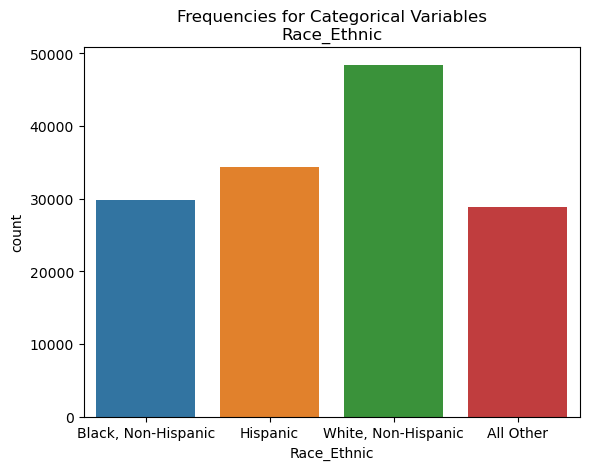


Frequencies for Categorical Variables

EDUC_LTD
                 Value  Frequency
0  High School Diploma      38366
1         Some College      38104
2            College +      37932
3                 < HS      27113


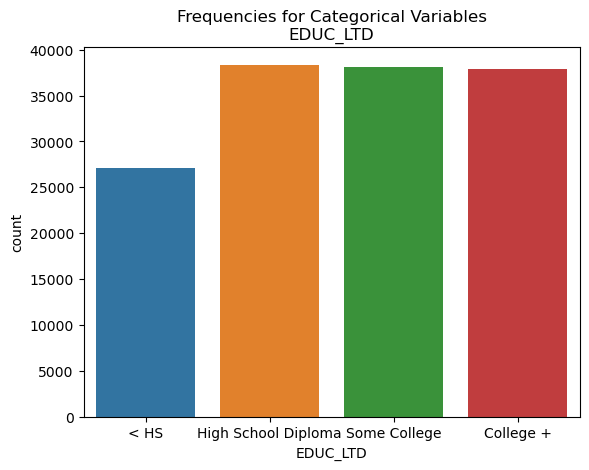


Frequencies for Categorical Variables

Child_Status
            Value  Frequency
0  Older Children      51117
1     No Children      48984
2       Child < 5      41414


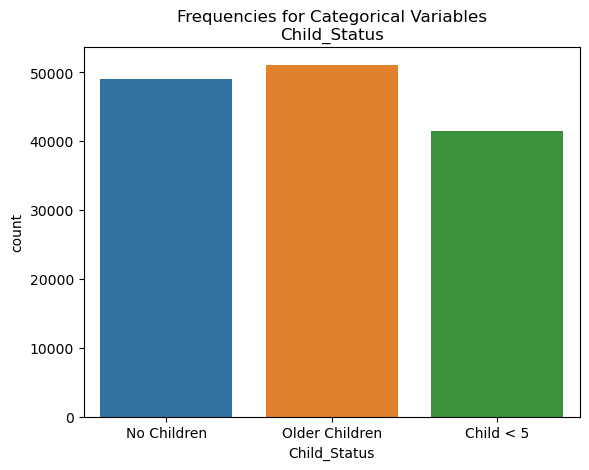


Frequencies for Categorical Variables

Unemp
   Value  Frequency
0    0.0     116058
1    1.0      25457


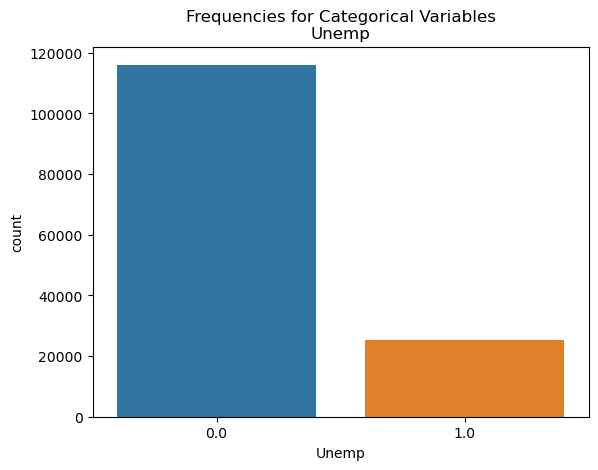


Frequencies for Categorical Variables

in_LF
   Value  Frequency
0    1.0      87679
1    0.0      53836


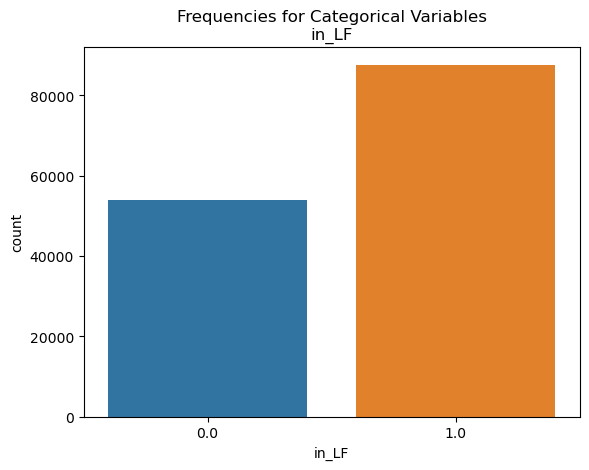

In [6]:
# Set the title for the frequency analysis
title = "Frequencies for Categorical Variables"

# Perform frequency analysis
categorical_variables = ['Race_Ethnic', 'EDUC_LTD', 'Child_Status', 'Unemp', 'in_LF']
for variable in categorical_variables:
    freq_table = acs_df[variable].value_counts().reset_index()
    freq_table.columns = ['Value', 'Frequency']
    
    # Print the frequency table
    print(f"\n{title}")
    print(f"\n{variable}")
    print(freq_table)
    
    # Create frequency plot
    sns.countplot(data=acs_df, x=variable)
    plt.title(f"{title}\n{variable}")
    plt.show()

Do you see any interesting trends in the underlying data?  Again, these data aren't weighted, so they don't represent U.S. averages. But they're a useful statistic nonetheless.

My interesting findings: (1) White, Non-Hispanic are in, by far, the most states across the United States. (2) There are several states in the U.S. that we couldn't calculate estimates for individuals with less than a high school level of education, because sample sizes were either too small or not available. (3) Most women in the data set (a) had children, (b) were in the labor force, and (c) were employed.

## Use SQL Code to Collapse Data to Get U.S. Estimates

As noted above, an observation in the data is a particular demographic group residing in a particular state in a given year. Because we have the weighed value for each cell,    we can use SQL to aggregate the data to the country level and give us a more precise U.S. average over time. Ready to see the how elegantly SQL can collapse data?  Well, I am!

In [7]:
results_dict = sas_session.submit(
    """
       libname acs "/home/student/S23HSRP";
        
        proc sql;
            create 	table acs.covid_labor_supply_us as 
            select	distinct 
                    yearquarter , 

        /*******************************************************************  Labor Force Status | All  */
                    sum( ( unemp=1 ) * WTFINL ) 											/ sum( ( in_LF=1 ) *   WTFINL )											as UE_Women				label="Unemployment Rate"	format percent9.1 		,
                    sum( ( in_LF=1 ) * WTFINL ) 											/ sum(  			   WTFINL ) 										as LFP_Women			label="LFP Rate"			format percent9.1 		,


        /*******************************************************************  Labor Force Status | By Race  */

                    /*******************************************************  Unemployment */
                    sum( ( race_ethnic="Black, Non-Hispanic" ) * ( unemp=1 ) * WTFINL ) 	/ sum( ( race_ethnic="Black, Non-Hispanic" ) * ( in_LF=1 ) * WTFINL ) 	as UE_BlackWomen		label="Black Women" 	format percent9.1 		,
                    sum( ( race_ethnic="Hispanic" ) * ( unemp=1 ) * WTFINL ) 				/ sum( ( race_ethnic="Hispanic" ) * ( in_LF=1 ) * WTFINL ) 				as UE_HispanicWomen		label="Hispanic Women" 	format percent9.1 		,
                    sum( ( race_ethnic="White, Non-Hispanic" ) * ( unemp=1 ) * WTFINL ) 	/ sum( ( race_ethnic="White, Non-Hispanic" ) * ( in_LF=1 ) * WTFINL ) 	as UE_WhiteWomen		label="White Women" 	format percent9.1 		,
                    sum( ( race_ethnic="All Other" ) * ( unemp=1 ) * WTFINL ) 				/ sum( ( race_ethnic="All Other" ) * ( in_LF=1 ) * WTFINL ) 			as UE_OtherWomen		label="All Other Women" format percent9.1 		,

                    /*******************************************************  LFP */
                    sum( ( race_ethnic="Black, Non-Hispanic" ) * ( in_LF=1 ) * WTFINL ) 	/ sum( ( race_ethnic="Black, Non-Hispanic" ) * WTFINL )					as LFP_BlackWomen		label="Black Women" 	format percent9.1 		,
                    sum( ( race_ethnic="Hispanic" ) * ( in_LF=1 ) * WTFINL ) 				/ sum( ( race_ethnic="Hispanic" ) * WTFINL ) 							as LFP_HispanicWomen	label="Hispanic Women" 	format percent9.1 		,
                    sum( ( race_ethnic="White, Non-Hispanic" ) * ( in_LF=1 ) * WTFINL ) 	/ sum( ( race_ethnic="White, Non-Hispanic" ) * WTFINL ) 				as LFP_WhiteWomen		label="White Women" 	format percent9.1 		,
                    sum( ( race_ethnic="All Other" ) * ( in_LF=1 ) * WTFINL ) 				/ sum( ( race_ethnic="All Other" ) * WTFINL )							as LFP_OtherWomen		label="All Other Women" format percent9.1 		,


        /*******************************************************************  Labor Force Status | By Education  */

                    /*******************************************************  Unemployment */
                    sum( ( educ_ltd="< HS" ) * ( unemp=1 ) * WTFINL ) 						/ sum( ( educ_ltd="< HS" ) * ( in_LF=1 ) * WTFINL )						as UE_Women_LTHS		label="EDUC < HS" 		format percent9.1 		,
                    sum( ( educ_ltd="High School Diploma" ) * ( unemp=1 ) * WTFINL ) 		/ sum( ( educ_ltd="High School Diploma" ) * ( in_LF=1 ) * WTFINL ) 		as UE_Women_HS			label="EDUC = HS" 		format percent9.1 		,
                    sum( ( educ_ltd="Some College" ) * ( unemp=1 ) * WTFINL ) 				/ sum( ( educ_ltd="Some College" ) * ( in_LF=1 ) * WTFINL ) 			as UE_Women_SCollege	label="Some College"	format percent9.1 		,
                    sum( ( educ_ltd="College +" ) * ( unemp=1 ) * WTFINL ) 					/ sum( ( educ_ltd="College +" ) * ( in_LF=1 ) * WTFINL ) 				as UE_Women_CollegeP	label="College +" 		format percent9.1 		,

                    /*******************************************************  LFP */
                    sum( ( educ_ltd="< HS" ) * ( in_LF=1 ) * WTFINL ) 						/ sum( ( educ_ltd="< HS" ) * WTFINL ) 									as LFP_Women_LTHS		label="EDUC < HS" 		format percent9.1 		,
                    sum( ( educ_ltd="High School Diploma" ) * ( in_LF=1 ) * WTFINL ) 		/ sum( ( educ_ltd="High School Diploma" ) * WTFINL ) 					as LFP_Women_HS			label="EDUC = HS" 		format percent9.1 		,
                    sum( ( educ_ltd="Some College" ) * ( in_LF=1 ) * WTFINL ) 				/ sum( ( educ_ltd="Some College" ) * WTFINL ) 							as LFP_Women_SCollege	label="Some College" 	format percent9.1 		,
                    sum( ( educ_ltd="College +" ) * ( in_LF=1 ) * WTFINL ) 					/ sum( ( educ_ltd="College +" ) * WTFINL ) 								as LFP_Women_CollegeP	label="College +" 		format percent9.1 		,


        /*******************************************************************  Labor Force Status | By Child Status  */

                    /*******************************************************  Unemployment */
                    sum( ( child_status="No Children" ) * ( unemp=1 ) * WTFINL ) 			/ sum( ( child_status="No Children" ) * ( in_LF=1 ) * WTFINL )			as UE_Women_NoKids		label="No Children" 	format percent9.1 		,
                    sum( ( child_status="Older Children" ) * ( unemp=1 ) * WTFINL ) 		/ sum( ( child_status="Older Children" ) * ( in_LF=1 ) * WTFINL ) 		as UE_Women_OlderKids	label="Older Children" 	format percent9.1 		,
                    sum( ( child_status="Child < 5" ) * ( unemp=1 ) * WTFINL ) 				/ sum( ( child_status="Child < 5" ) * ( in_LF=1 ) * WTFINL ) 			as UE_Women_YoungKids	label="Young Children"	format percent9.1 		,

                    /*******************************************************  LFP */
                    sum( ( child_status="No Children" ) * ( in_LF=1 ) * WTFINL ) 			/ sum( ( child_status="No Children" ) * WTFINL ) 						as LFP_Women_NoKids		label="No Children" 	format percent9.1 		,
                    sum( ( child_status="Older Children" ) * ( in_LF=1 ) * WTFINL ) 		/ sum( ( child_status="Older Children" ) * WTFINL ) 					as LFP_Women_OlderKids	label="Older Children" 	format percent9.1 		,
                    sum( ( child_status="Child < 5" ) * ( in_LF=1 ) * WTFINL ) 				/ sum( ( child_status="Child < 5" ) * WTFINL ) 							as LFP_Women_YoungKids	label="Young Children"	format percent9.1 		


            from 	acs.acs_2015_2022
            group	by 1 
            order	by 1 ;
        quit;

    """, 
)
    
covid_labor_supply_us_df = sas_session.sd2df(table="covid_labor_supply_us",libref="acs")

Lots of good stuff in that statement above. Note that we're collapsing to the yearquarter level - and incorporating the sample weight (that is, WTFINL) in the analysis.  Notice how succinct that code is - which would take many traditional Python or SAS commands if we went that route instead. <cr>
    
Let's now summarize the data one more time, to ensure that we aggregated the data properly. One bad sign would be to see unemployment rate and labor force participation rates either less than 0 or greater than 1.  Because those things shouldn't happen.

### Sanity Check: Do the Data Make Sense?
Let's print the data just to ensure that our data seem reasonable. The Python code:

In [8]:
#  Print the Data
covid_labor_supply_us_df

,YearQuarter,UE_Women,LFP_Women,UE_BlackWomen,UE_HispanicWomen,UE_WhiteWomen,UE_OtherWomen,LFP_BlackWomen,LFP_HispanicWomen,LFP_WhiteWomen,...,LFP_Women_LTHS,LFP_Women_HS,LFP_Women_SCollege,LFP_Women_CollegeP,UE_Women_NoKids,UE_Women_OlderKids,UE_Women_YoungKids,LFP_Women_NoKids,LFP_Women_OlderKids,LFP_Women_YoungKids
0,2015-01-01,0.047211,0.738310,0.087219,0.063629,0.034865,0.040917,0.769755,0.658631,0.761507,...,0.491811,0.668360,0.761317,0.826916,0.044699,0.047086,0.053703,0.769836,0.749805,0.646169
1,2015-04-01,0.045522,0.738932,0.075385,0.062764,0.034821,0.041100,0.770039,0.669844,0.761003,...,0.494933,0.674909,0.766443,0.822180,0.045454,0.042564,0.053918,0.770532,0.749338,0.648204
2,2015-07-01,0.048815,0.734344,0.077023,0.067676,0.038039,0.044745,0.766467,0.661662,0.758963,...,0.488201,0.672994,0.753138,0.818144,0.045646,0.049096,0.055920,0.768762,0.745102,0.637975
3,2015-10-01,0.042647,0.743679,0.074805,0.060602,0.030634,0.042491,0.766863,0.666811,0.767981,...,0.495868,0.675396,0.763120,0.830082,0.041248,0.041392,0.049534,0.779164,0.755620,0.643363
4,2016-01-01,0.044473,0.744559,0.083346,0.055370,0.032719,0.046326,0.758997,0.667180,0.771075,...,0.507608,0.672918,0.765526,0.829636,0.044324,0.042642,0.049949,0.776374,0.754748,0.652299
5,2016-04-01,0.041264,0.742937,0.064624,0.054351,0.031966,0.045198,0.760563,0.663884,0.771219,...,0.510625,0.670497,0.761224,0.828160,0.040296,0.040080,0.046987,0.769397,0.756774,0.653100
6,2016-07-01,0.046789,0.744580,0.073069,0.055856,0.036961,0.055377,0.773851,0.680854,0.766116,...,0.520268,0.678013,0.760150,0.824300,0.048399,0.044266,0.049508,0.776157,0.757724,0.647683
7,2016-10-01,0.040895,0.749199,0.068410,0.051406,0.031419,0.042302,0.782778,0.679291,0.771722,...,0.509389,0.681654,0.769555,0.829761,0.041890,0.038639,0.044475,0.785944,0.758116,0.652547
8,2017-01-01,0.041431,0.749183,0.071577,0.053231,0.032228,0.035445,0.767590,0.679051,0.773372,...,0.502559,0.670492,0.772951,0.832031,0.040332,0.041029,0.045335,0.783592,0.757086,0.656786
9,2017-04-01,0.038418,0.751382,0.064231,0.046475,0.030096,0.039340,0.779143,0.677983,0.774767,...,0.505116,0.686433,0.766346,0.830843,0.037329,0.038717,0.040439,0.786531,0.758786,0.657589


Let's further probe the data:

In [9]:
# Summarize the Data
summary_us = covid_labor_supply_us_df.describe()
summary_us = summary_us.round(3)  # Set the decimal places to 3

# Print the summary statistics
print(summary_us)

       UE_Women  LFP_Women  UE_BlackWomen  UE_HispanicWomen  UE_WhiteWomen  \
count    32.000     32.000         32.000            32.000         32.000   
mean      0.044      0.753          0.068             0.057          0.034   
std       0.018      0.010          0.020             0.025          0.015   
min       0.029      0.734          0.044             0.034          0.022   
25%       0.034      0.747          0.053             0.044          0.026   
50%       0.040      0.752          0.066             0.050          0.030   
75%       0.047      0.761          0.077             0.061          0.035   
max       0.120      0.776          0.141             0.164          0.100   

       UE_OtherWomen  LFP_BlackWomen  LFP_HispanicWomen  LFP_WhiteWomen  \
count         32.000          32.000             32.000          32.000   
mean           0.044           0.778              0.683           0.777   
std            0.022           0.011              0.015           0.010 

What do you see?  My musings: (1) there are 32 observations in the aggregated data set.  The math: 8 years * 4 quarters.  (2) The (weighted) average unemployment rate is 0.044 - or 4.4%.  This value is much lower than the 0.18 (18%) value reported above - which shows that weighting is consequential and likely higher in the smaller states. (3) We see that, in general, the unemployment rate decreases, and the labor force participation rate increases, as the level of education increases. All these nuggets make sense!

### Part 1 Recap

Our project is off to a great start.  We've imported the data, performed some preliminary data analysis using Python code, and collapsed the data using SQL.  But, we really haven't answered any of the interesting questions for HHS Leadership: namely (1) what are the UE and LFP trends over time and (2) are the levels back to "normal" after a COVID adjustment period? 

We'll tackle these questions better in Parts 2 and 3 of this analysis.